In [1]:
import sys
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_validate

from sklearn.pipeline import make_pipeline

from sklearn import metrics

import mlflow
local_tracking_uri = os.path.abspath('../' + 'mlruns')
mlflow.set_tracking_uri(local_tracking_uri)

mlflow_client = mlflow.tracking.MlflowClient()

# Custom modules

import sys
import os
ROOT_DIR = os.path.abspath('../')
sys.path.insert(0, ROOT_DIR + "/src")

import utils

# Approach

- Based on EDA results from notebook `01_eda`, the baseline we're going to use is 55% accuracy by predicting all customers being female.
- Given this dataset and a timeline of a few days, a reasonable goal is to build a classifier with 70% accuracy.

# Constants

In [34]:
TRAIN_INPUT_PATH = '../data/process/train_feature.csv'
TEST_INPUT_PATH = '../data/process/test_feature.csv'
LABEL_COL = 'gender_first'

SCORING = ['roc_auc', 'f1_micro', 'f1_weighted', 'precision', 'recall']

# Load input

In [35]:
train_df = pd.read_csv(TRAIN_INPUT_PATH)
test_df = pd.read_csv(TEST_INPUT_PATH)

In [36]:
train_df

,step_count,step_mean,step_median,age_first,merchant_nunique,category_nunique,amount_mean,amount_median,amount_max,amount_min,...,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty
0,131,107.786260,106.0,5,14,10,35.091908,26.14,323.64,0.80,...,1,1,1,0,2,1,2,114,0,2
1,109,124.532110,134.0,4,22,11,90.336239,35.13,3902.93,1.37,...,2,2,2,0,0,3,0,65,1,17
2,94,51.436170,49.5,4,10,7,38.154894,28.32,326.34,0.99,...,0,1,1,0,1,0,0,80,0,4
3,30,91.833333,94.5,1,11,6,204.754667,103.68,1260.94,1.05,...,1,0,0,0,0,5,1,0,0,6
4,131,107.702290,109.0,3,17,12,34.253282,29.94,197.30,0.59,...,1,0,4,0,1,2,1,108,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3275,175,89.891429,91.0,3,14,9,32.555771,26.63,241.58,0.17,...,1,0,1,0,0,0,4,153,0,4
3276,171,89.005848,89.0,2,11,10,61.211637,26.22,5527.37,0.41,...,0,0,2,0,0,0,1,155,2,1
3277,177,90.107345,91.0,2,8,6,32.273107,26.20,219.99,0.54,...,0,0,0,0,0,0,0,150,0,1
3278,142,104.992958,107.5,1,16,8,36.018944,26.00,476.43,0.12,...,1,0,4,0,0,1,0,109,0,16


In [77]:
all_df = pd.concat([train_df, test_df], axis=0)

# Generate X, y

In [37]:
le = LabelEncoder()

In [38]:
X_train, y_train = train_df.drop(columns=[LABEL_COL]), le.fit_transform(train_df[LABEL_COL])
X_test, y_test = test_df.drop(columns=[LABEL_COL]), le.transform(test_df[LABEL_COL])
X_all, y_all = all_df.drop(columns=[LABEL_COL]), le.transform(all_df[LABEL_COL])

# Transform

In [39]:
scaler = StandardScaler()

# Fit

In [83]:
clf_name = "RandomForest"

In [95]:
clf_params = {
              'n_estimators': 1000,
              'min_samples_split': 20,
              'max_depth': 6,
              'min_samples_leaf': 20
             }

In [96]:
clf = RandomForestClassifier(**clf_params)

In [119]:
pipeline = make_pipeline(clf)

In [120]:
%%time
pipeline.fit(X_train, y_train)

CPU times: user 2.8 s, sys: 93.8 ms, total: 2.89 s
Wall time: 2.9 s


Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=20,
                                        min_samples_split=20,
                                        n_estimators=1000))])

# Evaluate

## Cross Validation

In [126]:
train_score = cross_validate(pipeline, X_all, y_all, scoring=SCORING,
                             cv=5, return_train_score=True)

train_score_df = pd.DataFrame(train_score)
display(train_score_df)

train_score_agg_dict = train_score_df.mean(axis=0).to_dict()

train_score_agg_dict

,fit_time,score_time,test_roc_auc,train_roc_auc,test_f1_micro,train_f1_micro,test_f1_weighted,train_f1_weighted,test_precision,train_precision,test_recall,train_recall
0,2.837357,0.229099,0.505609,0.744607,0.551220,0.586890,0.426345,0.477091,0.514286,0.861446,0.048780,0.096949
1,3.006632,0.209871,0.543033,0.787872,0.552439,0.569512,0.400035,0.433840,0.666667,0.956522,0.010840,0.044746
2,3.031814,0.215451,0.502280,0.757370,0.546341,0.595427,0.410921,0.494971,0.440000,0.862745,0.029810,0.119322
3,3.209876,0.232659,0.517291,0.761271,0.551220,0.574085,0.409581,0.442853,0.529412,0.975610,0.024390,0.054237
4,3.033458,0.243873,0.523921,0.795367,0.551220,0.565244,0.396070,0.423688,0.500000,1.000000,0.005435,0.033875


{'fit_time': 3.0238274574279784,
 'score_time': 0.2261904239654541,
 'test_roc_auc': 0.5184269650474943,
 'train_roc_auc': 0.7692976627349748,
 'test_f1_micro': 0.5504878048780488,
 'train_f1_micro': 0.5782317073170731,
 'test_f1_weighted': 0.40859037407657245,
 'train_f1_weighted': 0.45448878174074603,
 'test_precision': 0.5300728291316525,
 'train_precision': 0.9312644752799484,
 'test_recall': 0.023851184164015556,
 'train_recall': 0.06982591520830463}

## Holdout

In [110]:
holdout_score_agg_dict = dict()
for scorer_name in SCORING:
    scorer = metrics.get_scorer(scorer_name)
    score = scorer(pipeline, X_test, y_test)
    holdout_score_agg_dict[f"holdout_{scorer_name}"] = score    

In [104]:
holdout_score_agg_dict

{'holdout_roc_auc': 0.5213004484304933,
 'holdout_f1_micro': 0.5451219512195122,
 'holdout_f1_weighted': 0.39023827846325015,
 'holdout_precision': 0.6,
 'holdout_recall': 0.008021390374331552}

### Store run info in MLflow

In [112]:
experiment = mlflow.set_experiment("10-try-out-clfs")

In [113]:
with mlflow.start_run(experiment_id=experiment):
    mlflow.log_param('data', 'fe21')
    mlflow.log_param('num_tf', None)
    mlflow.log_param('clf', clf_name)
    mlflow.log_params(clf_params)
    mlflow.log_metrics({**train_score_agg_dict, **holdout_score_agg_dict})
    mlflow.set_tag("issue", "10")

# Feature importance

In [114]:
fi_df = pd.DataFrame({'fi': clf.feature_importances_}, index=X_train.columns)
fi_df.sort_values(['fi'], ascending=False).head(20) \
    .style.bar()

,fi
amount_std,0.054772
step_mean,0.053569
amount_max,0.051621
amount_min,0.048665
amount_median,0.046418
amount_mean,0.043769
step_median,0.042218
merchant_M348934600,0.039210
category_es_health,0.036122
merchant_M1823072687,0.035884


# Learning curve

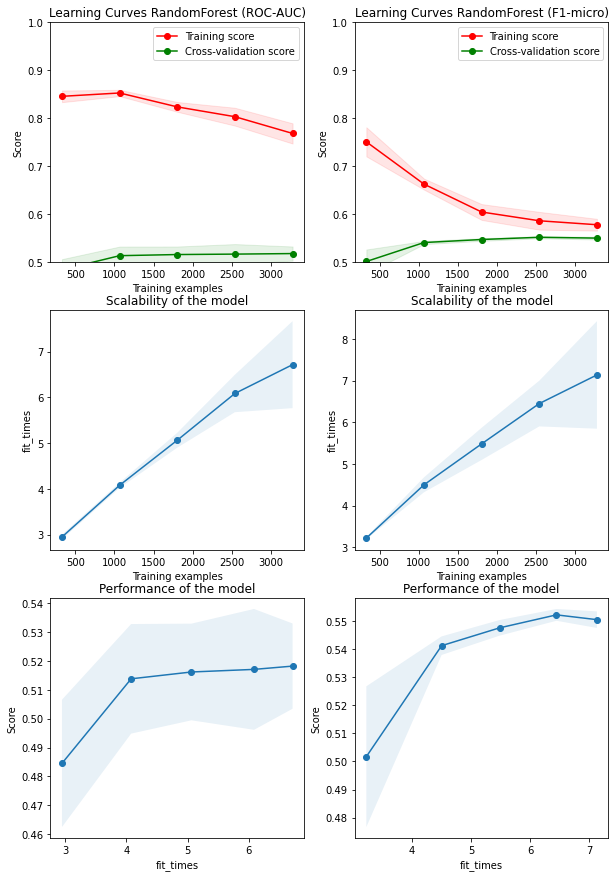

In [115]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
cv = 5
title = f"Learning Curves {clf_name} (ROC-AUC)"
train_sizes, train_scores, test_scores = \
    utils.plot_learning_curve(clf, title, X_all, y_all, axes=axes[:, 0], ylim=(0.7, 1.01),
                              cv=cv, n_jobs=8, scoring='roc_auc')

title = f"Learning Curves {clf_name} (F1-micro)"
train_sizes, train_scores, test_scores = \
    utils.plot_learning_curve(clf, title, X_all, y_all, axes=axes[:, 1], ylim=(0.7, 1.01),
                              cv=cv, n_jobs=8, scoring='f1_micro')

plt.show()

The above learning curve shows that performance plateaus at 2500 observations. If continuing with the same pipeline might, even more data can not help much -> Should focus on feature engineering.

# SelectFromModel

In [130]:
clf = pipeline.named_steps['randomforestclassifier']

fs = SelectFromModel(clf, prefit=True)

X_fs = fs.transform(X_all)

X_fs.shape

(4100, 24)

In [129]:
fs_score = cross_validate(pipeline, X_fs, y_all, scoring=SCORING,
                          cv=5, return_train_score=True)

fs_score_df = pd.DataFrame(fs_score)
display(fs_score_df)

fs_score_agg_dict = fs_score_df.mean(axis=0).to_dict()

fs_score_agg_dict

,fit_time,score_time,test_roc_auc,train_roc_auc,test_f1_micro,train_f1_micro,test_f1_weighted,train_f1_weighted,test_precision,train_precision,test_recall,train_recall
0,2.951502,0.211574,0.512454,0.758964,0.550000,0.607012,0.440684,0.519536,0.500000,0.852273,0.073171,0.152542
1,3.032460,0.209526,0.542702,0.789707,0.550000,0.590244,0.414730,0.476800,0.500000,0.958042,0.032520,0.092881
2,2.983970,0.324014,0.499691,0.763105,0.546341,0.607927,0.430439,0.520815,0.468085,0.856604,0.059621,0.153898
3,2.996175,0.226701,0.530102,0.774009,0.551220,0.581098,0.411535,0.458401,0.526316,0.954955,0.027100,0.071864
4,3.697191,0.272961,0.520964,0.785343,0.548780,0.586280,0.403194,0.468907,0.428571,0.961240,0.016304,0.084011


{'fit_time': 3.132259893417358,
 'score_time': 0.2489549160003662,
 'test_roc_auc': 0.5211823649680825,
 'train_roc_auc': 0.7742256160210388,
 'test_f1_micro': 0.5492682926829269,
 'train_f1_micro': 0.5945121951219512,
 'test_f1_weighted': 0.4201164720894254,
 'train_f1_weighted': 0.48889198419914315,
 'test_precision': 0.48459446488561825,
 'train_precision': 0.916622744786413,
 'test_recall': 0.04174325438906563,
 'train_recall': 0.11103945615727344}

In [133]:
with mlflow.start_run(experiment_id=experiment):
    mlflow.log_param('data', 'fe21')
    mlflow.log_param('num_tf', None)
    mlflow.log_param('clf', clf_name)
    mlflow.log_param('cnt_features', X_fs.shape[1])
    mlflow.log_params(clf_params)
    mlflow.log_metrics(fs_score_agg_dict)
    mlflow.set_tag("issue", "10")

Reducing from 86 features to 24 features does not affect model's performance. In production, this will be a huge advantages because of less complexity, less time required to produce and maintain the features.

# Archive

In [52]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

# MLflow

In [167]:
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.holdout_precision,metrics.train_precision,metrics.holdout_f1_weighted,metrics.score_time,...,params.clf,params.data,params.max_iter,params.num_tf,params.cv,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.note.content,tags.eval_set
0,cfe84ff3ee5341cc889f79ba61d8acda,0,FINISHED,/home/quydv1/frostmourne/lich/banksim/mlruns/0...,2020-07-14 17:34:04.895000+00:00,2020-07-14 17:34:05.056000+00:00,0.479592,0.556411,0.500156,0.021375,...,LogisticRegression,fe2,2000,PowerTransformer,None,/home/quydv1/anaconda3/envs/banksim/lib/python...,LOCAL,quydv1,None,None
1,a1448fafcd924ea385ed2b33e2717a04,0,FINISHED,/home/quydv1/frostmourne/lich/banksim/mlruns/0...,2020-07-14 17:28:26.927000+00:00,2020-07-14 17:28:27.089000+00:00,0.460432,0.544958,0.471899,0.009517,...,LogisticRegression,fe2,2000,StandardScaler,None,/home/quydv1/anaconda3/envs/banksim/lib/python...,LOCAL,quydv1,None,None
2,41b94130e16048d88fa703a44f39ff8f,0,FINISHED,/home/quydv1/frostmourne/lich/banksim/mlruns/0...,2020-07-14 16:26:50.776000+00:00,2020-07-14 16:26:50.840000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,/home/quydv1/anaconda3/envs/banksim/lib/python...,LOCAL,quydv1,None,None
3,2b054f5f9ec7457fbbdcc66fb1212b7e,0,FINISHED,/home/quydv1/frostmourne/lich/banksim/mlruns/0...,2020-07-14 16:06:36.456000+00:00,2020-07-14 16:06:36.604000+00:00,NaN,0.200000,NaN,0.012698,...,LogisticRegressionCV,fe1,1000,PowerTransformer,5,/home/quydv1/anaconda3/envs/banksim/lib/python...,LOCAL,quydv1,Ignore results due to a bug at https://github....,train


In [168]:
run_obj = mlflow_client.get_run('cfe84ff3ee5341cc889f79ba61d8acda')

In [169]:
mlflow_client.set_tag(run_obj.info.run_id, "issue", "9")

In [ ]:
run_obj.data